<a href="https://www.kaggle.com/code/gazu468/classification-with-pytorch?scriptVersionId=106421308" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
from torch.utils.data import random_split

It contains 2 folders `train` and `test`, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using `os.listdir`.

In [2]:
data_dir = '../input/cifar10-classification-image/cifar10/'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'horse', 'truck', 'automobile', 'ship', 'dog', 'bird', 'frog', 'cat', 'deer']


Let's look inside a couple of folders, one from the training set and another from the test set. As an exercise, you can verify that that there are an equal number of images for each class, 5000 in the training set and 1000 in the test set.

In [3]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print("No. of Training example for airplane", len(airplane_files))
print(airplane_files[:5])

No. of Training example for airplane 5000
['0566.png', '4353.png', '2664.png', '0115.png', '2539.png']


In [4]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("NO. of testing example for ship", len(ship_test_files))
print(ship_test_files[:5])

NO. of testing example for ship 1000
['0566.png', '0115.png', '0050.png', '0501.png', '0263.png']


 We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [5]:
dataset = ImageFolder(data_dir + "train", transform=ToTensor())

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels <b>(RGB)</b>, each image tensor has the shape `(3, 32, 32)`.

In [6]:
# dataset[0]

In [7]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

The list of classes is stored in the `.classes ` property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes

In [8]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
def show_example(img, label):
    print("label :", dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

label : airplane (0)


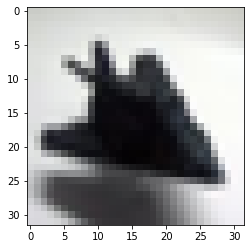

In [10]:
show_example(*dataset[0])

label : airplane (0)


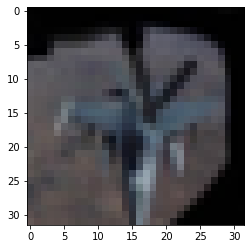

In [11]:
show_example(*dataset[10])

### Training and Validation Datasets

- Training : Used to train a model and adjust the weightes with gradient descent.
- Validation : Used to tuning those hyperparameters also learning rate and pick best version of the model.
- Testing : Chose model based on performence form several models

In [12]:
randoem_seed = 42
torch.manual_seed(randoem_seed)

In [13]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds , val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

We can now create data loaders for training and validation, to load the data in batches

### Load Data

In [14]:
from torch.utils.data.dataloader import DataLoader
batch_size= 128

In [15]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers=4, pin_memory=True )
val_dl= DataLoader(val_ds, batch_size, num_workers=4, pin_memory=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### TorchVision

 We can look at batches of images from the dataset using the make_grid method from torchvision

In [16]:
from torchvision.utils import make_grid

def show_grid(imgs):
    for images ,label in imgs:
        fix, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

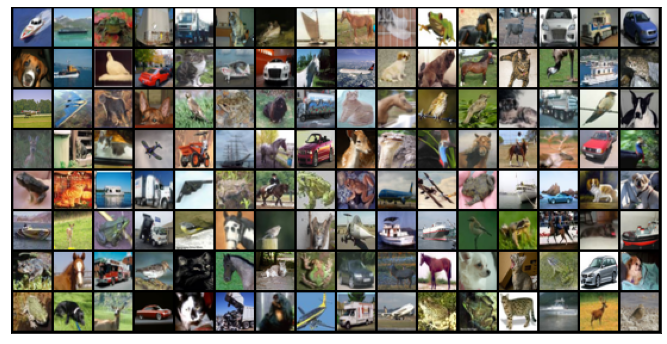

In [17]:
show_grid(train_dl)

### Defining the Model (Convolutional Neural Network)

Let us implement a convolution operation on a 1 channel image with a 3x3 kernel

In [18]:
def apply_kernel(image, kernel):
    ri, ci =image.shape   #image dimention
    rk, ck= kernel.shape  #kernel dimenton
    ro, co = ri-rk+1, ci-ck+1  #output dimention
    output = torch.zeros([ro,co])
    for i in range(ro):
        for j in range(co):
            output[i,j]=torch.sum(image[i: i+rk, j:j+ck] * kernel)
    return output


In [19]:
sample_image =torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]  
], dtype=torch.float32)

sample_kernel=torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
], dtype= torch.float32)

In [20]:
apply_kernel(sample_image,sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise.

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

There are certain advantages offered by convolutional layers when working with image data:

* <b>Fewer parameters :</b> A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer.
* <b>Sparsity of connections:</b> In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* <b>Parameter sharing and spatial invariance: </b> The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

In [21]:
sample_model = nn.Sequential(nn.Conv2d(3, 8,kernel_size=3, stride=1, padding=1),
                             nn.MaxPool2d(2,2)
                            )

In [22]:
for images, labels in train_dl:
    print("image shape", images.shape)
    out = sample_model(images)
    print("out shape", out.shape)
    break

image shape torch.Size([128, 3, 32, 32])
out shape torch.Size([128, 8, 16, 16])


Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for `training & validation`

In [23]:
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images, labels =batch
        out = self(images)#generate prediction
        loss =F.cross_entropy(out, labels)  #calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels =batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epochs [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc {:.4f}".format(epoch, result['train_loss'],
                                                                                        result['val_loss'],result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [24]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [25]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

Recall Tomorrow

In [26]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0239, -0.0466,  0.0067,  0.0193,  0.0044, -0.0598, -0.0188, -0.0242,
         0.0431, -0.0164], grad_fn=<SelectBackward0>)


In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

### Training the Model

In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
model = to_device(Cifar10CnnModel(), device)

In [32]:
evaluate(model, val_dl)

{'val_loss': 2.3021087646484375, 'val_acc': 0.10039062798023224}

In [33]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epochs [0], train_loss: 1.7577, val_loss: 1.3663, val_acc 0.4906
Epochs [1], train_loss: 1.2550, val_loss: 1.0824, val_acc 0.5963
Epochs [2], train_loss: 0.9927, val_loss: 0.8951, val_acc 0.6750
Epochs [3], train_loss: 0.8047, val_loss: 0.8063, val_acc 0.7189


We can also plot the valdation set accuracies to study how the model improves over time.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point!

This phenomenon is called <b>overfitting</b>, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.

Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase

## Lets Testing Individuals Image

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by creating a test dataset using the ImageFolder class.

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

Let's define a helper function `predict_image,` which returns the predicted label for a single image tensor

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.